# Seasonality & Correlating Time Series 

# Seasonality 

In the last practices we only briefly touched on seasonality. We looked at some data that seemed to have seasonal trends, but we mainly focused on checking for stationarity & reducing noise rather than trying to understand the seasonality in the series. 

Let's start by bringing in data on Australia's weather obtained [here](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package), isolating the measurements in Perth, and saving only a few select columns. 

In [134]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from pandas.tseries.frequencies import to_offset
import statsmodels as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy

def run_adfuller(timeseries):
    # drop nans
    timeseries = timeseries.dropna()
    # run test
    dftest  = stattools.adfuller(timeseries)
    # printer
    if dftest[0] < dftest[4]['1%']:
        print('the time series is stationary within a 99% confidence level')
    if dftest[0] > dftest[4]['1%']:
        print('the time series is not stationary')
    # return 
    return dftest

In [135]:
aus = pd.read_csv('weatherAUS.csv')
perth = aus[aus['Location'] == 'Perth']
#perth = perth[['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Pressure3pm']]
perth['Date'] = pd.to_datetime(perth['Date'])
perth.reset_index(inplace = True, drop = True)
perth.head()

<ipython-input-135-52308fbb3738>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perth['Date'] = pd.to_datetime(perth['Date'])


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-07-01,Perth,2.7,18.8,0.0,0.8,9.1,ENE,20.0,NaN,...,97.0,53.0,1027.6,1024.5,2.0,3.0,8.5,18.1,No,No
1,2008-07-02,Perth,6.4,20.7,0.0,1.8,7.0,NE,22.0,ESE,...,80.0,39.0,1024.1,1019.0,0.0,6.0,11.1,19.7,No,No
2,2008-07-03,Perth,6.5,19.9,0.4,2.2,7.3,NE,31.0,NaN,...,84.0,71.0,1016.8,1015.6,1.0,3.0,12.1,17.7,No,Yes
3,2008-07-04,Perth,9.5,19.2,1.8,1.2,4.7,W,26.0,NNE,...,93.0,73.0,1019.3,1018.4,6.0,6.0,13.2,17.7,Yes,Yes
4,2008-07-05,Perth,9.5,16.4,1.8,1.4,4.9,WSW,44.0,W,...,69.0,57.0,1020.4,1022.1,7.0,5.0,15.9,16.0,Yes,Yes


In [136]:
# interpolate where needed
for col in perth.columns:
    if perth[col].isna().sum() > 0:
        perth[col] = perth[col].interpolate(method ='linear')

<ipython-input-136-049936a777cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perth[col] = perth[col].interpolate(method ='linear')


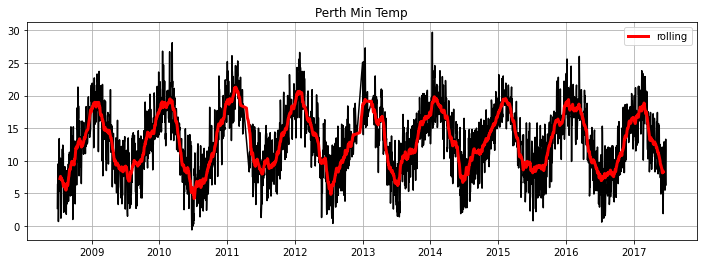

In [137]:
# plotperth_roll = perth.set_index('Date').rolling(30).mean().reset_index()
perth_roll['Date offset'] = perth_roll['Date'] - to_offset('15D')

plt.figure(figsize = (12, 4))
plt.plot(perth['Date'], perth['MinTemp'], c = 'k')
plt.plot(perth_roll['Date offset'], perth_roll['MinTemp'], c = 'r', linewidth = 3, label = 'rolling')
plt.title('Perth Min Temp')
plt.legend()
plt.grid()

## Differencing to Remove Seasonality 

We've looked at examples that use differencing, including differencing to make a non-stationary time series stationary. In a similar manner, we can use differencing to **remove the seasonal trend** from our time series. This means removing the repeating pattern to reveal the underlying trend. To fully grasp this we need to understand that every time series is a sum of parts, including the **trend** (increasing or decreasing), **seasonal component** (repeating cycles of any length, not just yearly), and any **residal** (noise). This step is meant to remove the seasonal component, leaving behind only the trend and residual.  

In order to implement differencing to remove seasonality, we must first figure out *how much* to difference. We can get insight on this by using an **autocorrelation plot**! Let's create one with 50 lags to start.  

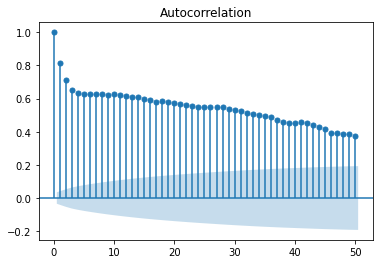

In [138]:
tsaplots.plot_acf(perth['MinTemp'], lags=50);

It looks like there is a strong correlation with values & past values so we know there is some sort of trend at hand. See we only used a lag of 50 values. Eyeballing from the figure it looks like it takes around 300-400 values for a full cycle to complete (in this case common sense tells us it's 365 days but that won't always be the case!). Let's readjust to have a wider window so we can see the autocorrelation in a length longer than the full cycle. 

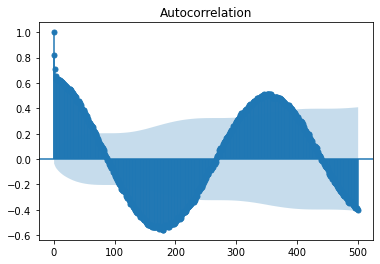

In [139]:
tsaplots.plot_acf(perth['MinTemp'], lags=500);

Wow what a difference! We see a strong cycle with the length on the order of 365 days. Let's implement differencing using our newfound length of the seasonal cycle. & plot together with the original so we can see the difference. 

<ipython-input-140-7b09f7a5abe7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perth['MinTemp deseasoned'] = perth['MinTemp'] - perth['MinTemp'].shift(365)


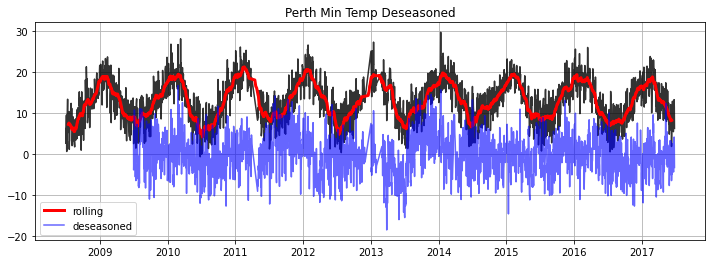

In [140]:
# deseason
perth['MinTemp deseasoned'] = perth['MinTemp'] - perth['MinTemp'].shift(365)

# plot 
plt.figure(figsize = (12, 4))
plt.plot(perth['Date'], perth['MinTemp'], alpha = 0.8, c = 'k')
plt.plot(perth_roll['Date offset'], perth_roll['MinTemp'], c = 'r', linewidth = 3, label = 'rolling')
plt.plot(perth['Date'], perth['MinTemp deseasoned'], c = 'b', alpha = 0.6, label = 'deseasoned')
plt.title('Perth Min Temp Deseasoned')
plt.legend()
plt.grid()

You see that the seasonal cycles have all been removed! The trend has been flattened to remove the peaks and valleys. You'll also see that the mean has been reduced to zero & there is no upward or downward trend. What we are left with is the residual!

If you think this looks an awful lot like when we used differencing to make a series stationary, you're right! Running the Dickey Fuller test shows that in the process of deseasoning we have also made a non-stationary series stationary. 

In [141]:
dftest = run_adfuller(perth['MinTemp deseasoned'])

the time series is stationary within a 99% confidence level


# Automatic decomposition 

It is useful to decompose a time series into its parts (seasonal cycle, trend, residual) and look at all of them independently. We consider a time series to follow an **agrregate model** where all the components are combined in some way to make the full time series. We can use the `seasonal_decompose` function from `statsmodel`'s `tsa.seasonal` toolkit to automatically separate into individual components. 

While this is an extremely powerful tool, it is important to treat the results with a lot of skepticism! You will need to choose a `model` input parameter that indicates if your time series follows an **additive or multiplicative model**.

In an **additive model** time series, each components adds together to make the time series. This is usually: 

- a straight, linear trend
- a consistent change in amount over time 
- if there is seasonality, the frequency (cycle width) and amplitude (cycle height) will be constant over time 

In a **multiplicative model** time series, each component multiplies together to make the total time series. This is usually: 

- nonlinear, can be quadratic or exponential 
- does not have a consistent change in amount over time, changes can increase or decrease with time 
- if there is seasonality, the frequency and amplitide change over time 

The function will usually produce a result no matter the model input so be **skeptical** of your result and consider that your time series may not be stricly either of these models. 

Our `perth['MinTemp']` data more closely resembles the additive model so let's run `seasonal_decompose` using that input argument. We also have to specify a `period`, which with our autocorrelation plot we learned was 365.

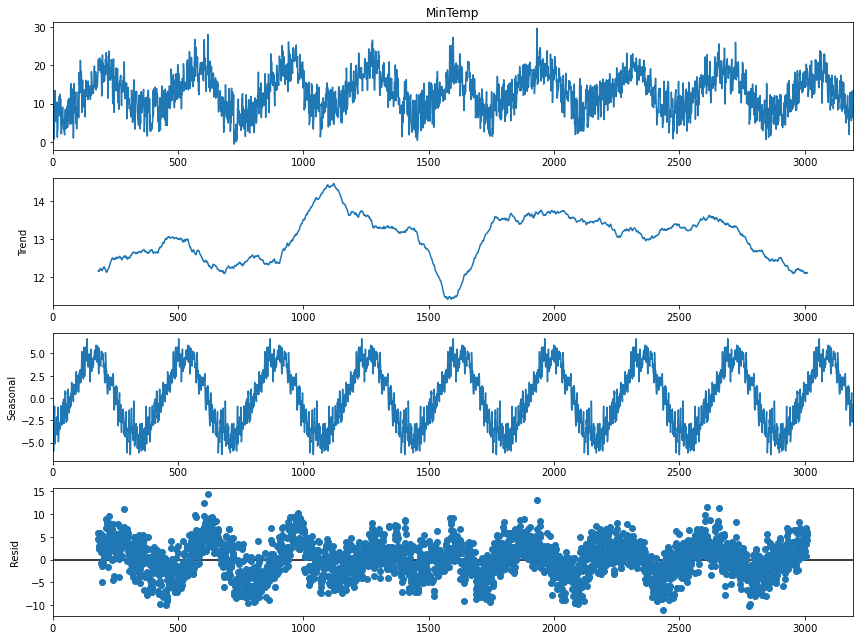

In [142]:
mintemp_decomp = sm.tsa.seasonal.seasonal_decompose(perth['MinTemp'], model="additive", period=365)
fig = mintemp_decomp.plot()
fig.set_size_inches((12, 9))
fig.tight_layout()
plt.show()

Our time series has sucessfully been decomposed into components! 

The top figure shows the original time series, followed by 'Trend', which shows both increasing and decreasing trend over time. Below that is the figure showing the strong seasonal cycle, and finally at the bottom we have been returned the residuals. 

<hr style="border:2px solid gray"> </hr>

### Now you try! 

Decompose the `perth['Rainfall']` time series into its components, assuming it has the same 365 day period as the minimum temperature. 

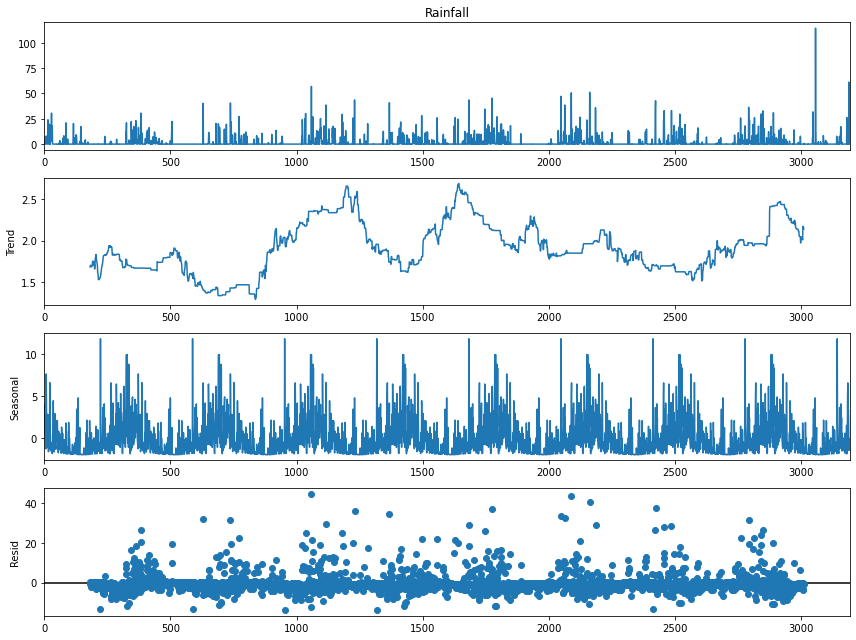

In [143]:
mintemp_decomp = sm.tsa.seasonal.seasonal_decompose(perth['Rainfall'], model="additive", period=365)
fig = mintemp_decomp.plot()
fig.set_size_inches((12, 9))
fig.tight_layout()
plt.show()

<hr style="border:2px solid gray"> </hr>

# Correlation Between Multiple Time Series

You'll often find yourself in situations where you have multiple time series at once - maybe you're analyzing a sceneario where you have a series of paint sales over time & want to see if this correlates at all with the number of promotional emails or season. 

The first thing we can do is plot a **correlation matrix** of the datasets. For this we can use the pandas function `.corr()`. This will calculate correlation between every column in the dataframe, giving us a way to **quantify the synchronisity between the two time series**. 

For some review on the correlation coefficient refer to [this](https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/) page and the following image. Recall that a correlation coefficient (usually Pearson's R) of 1 means the two variables grow in perfect porportion with eachother. A value of -1 indicates that as one variable increases, the other decreases in perfect porportion. Zero means they are unrealated. 

If we wanted to communicate the strength of the relationship, we take the absolute value of R. 

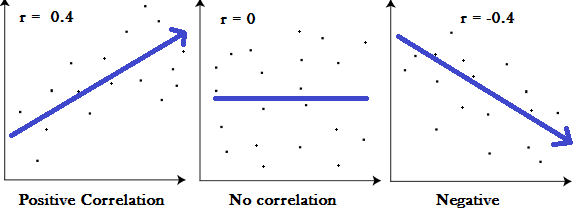


Let's see if the `MinTemp` and `MaxTemp` time series' in `perth` have any correlation. We will use `.corr()` to get the correlation matrix, then plot it in a way that shows the highest R values in the brightest red, and the lowest R values in the darkest blue. This figure will work with any diverging colormap (`Spectral`, `RdGy`, `seismic`). 

We will also demonstrate using linear regression to get the R value for the relationship between `MinTemp` and `MaxTemp` values. 

Text(0, 0.5, 'Rainfall')

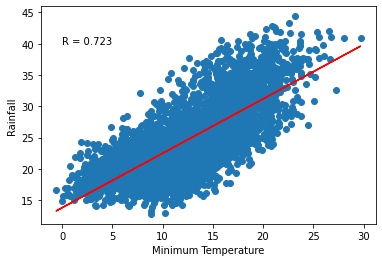

In [144]:
# plot best fit line 
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(perth['MinTemp'], perth['MaxTemp'])
yline = intercept + slope * perth['MinTemp']


# plot 
plt.scatter(perth['MinTemp'], perth['MaxTemp'])
plt.plot(perth['MinTemp'], yline, 'r')
plt.text(0, 40, 'R = ' + str(round(r_value, 3)))
plt.xlabel('Minimum Temperature')
plt.ylabel('Rainfall')

In [145]:
#perth.drop(columns = 'MinTemp deseasoned', inplace = True)
perth_corr = perth.corr()
perth_corr.style.background_gradient(cmap='coolwarm')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,MinTemp deseasoned
MinTemp,1.000000,0.723314,-0.033514,0.707286,0.176020,0.355402,0.341856,0.326346,-0.369556,-0.114219,-0.648828,-0.657026,0.102075,-0.006227,0.862370,0.680101,0.470982
MaxTemp,0.723314,1.000000,-0.287877,0.798864,0.548053,0.094016,0.235955,0.126076,-0.680115,-0.588965,-0.363295,-0.475495,-0.327500,-0.324302,0.899724,0.977493,0.156744
Rainfall,-0.033514,-0.287877,1.000000,-0.213480,-0.308982,0.234127,0.041660,0.070173,0.328610,0.320031,-0.225141,-0.127770,0.253769,0.217887,-0.190691,-0.304319,0.127541
Evaporation,0.707286,0.798864,-0.213480,1.000000,0.532053,0.293332,0.361847,0.329104,-0.668897,-0.466368,-0.422777,-0.489891,-0.231119,-0.289220,0.799584,0.768943,0.150928
Sunshine,0.176020,0.548053,-0.308982,0.532053,1.000000,0.045597,0.169301,0.249169,-0.571964,-0.627281,0.048287,-0.029187,-0.679893,-0.710751,0.429754,0.562455,-0.172386
WindGustSpeed,0.355402,0.094016,0.234127,0.293332,0.045597,1.000000,0.552688,0.658289,-0.205303,0.086790,-0.505025,-0.465424,0.124994,0.058941,0.254006,0.039724,0.271191
WindSpeed9am,0.341856,0.235955,0.041660,0.361847,0.169301,0.552688,1.000000,0.336757,-0.431438,-0.188844,-0.270063,-0.278067,-0.023072,-0.048552,0.299768,0.220558,0.205007
WindSpeed3pm,0.326346,0.126076,0.070173,0.329104,0.249169,0.658289,0.336757,1.000000,-0.233117,0.060197,-0.413543,-0.364856,0.015407,-0.087747,0.303741,0.057648,0.145012
Humidity9am,-0.369556,-0.680115,0.328610,-0.668897,-0.571964,-0.205303,-0.431438,-0.233117,1.000000,0.665872,0.147758,0.239003,0.389176,0.338240,-0.656535,-0.655864,-0.009221
Humidity3pm,-0.114219,-0.588965,0.320031,-0.466368,-0.627281,0.086790,-0.188844,0.060197,0.665872,1.000000,-0.200747,-0.075033,0.490332,0.536932,-0.347389,-0.671435,0.152462


See that the R value of 0.723 calculated for the linear regression of `MinTemp` and `MaxTemp` is the same as that in the correlation plot! This is because the correlation plot basically completes that regression process with every pair of variables in the dataframe. It seems that `MaxTemp` and and `Evaporation` have the strongest correlation because the value 0.798 has the largest magnitude in `perth_corr`! 

## Ploting Multiple Time Series Together 

Let's say we want to dive deeper into the relationship between two time series. Let's plot the two series together. 

Text(0, 0.5, 'Degrees or centimeters??')

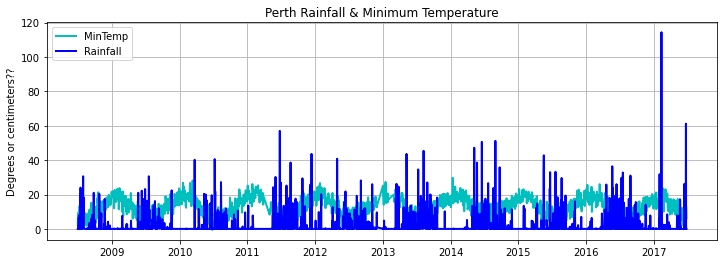

In [146]:
plt.figure(figsize = (12, 4))
plt.plot(perth['Date'], perth['MinTemp'], linewidth = 2, c = 'c', label = 'MinTemp')
plt.plot(perth['Date'], perth['Rainfall'], linewidth = 2, c = 'b',  label = 'Rainfall')
plt.title('Perth Rainfall & Minimum Temperature')
plt.grid()
plt.legend()
plt.ylabel('Degrees or centimeters??')

The precipitation data looks okay but the temperature time series is now squashed and is being obscured by the overlap! These two variables have different scales, so it is difficult to simply share an axis between them. Furthermore, what would be the unit on the y axis? Would it be degrees or centimeters? It is difficult to make two variables share a y axis! 

It would be useful if we could share the same figure space but have a separatel labeled y axis for each variable. Using `twinx()` we can do just that. It will duplicate the axis space in a way that both the initial and duplicate share an x axis. We will also set the `alpha` parameter which indicates transparency of the plot line so data is not totally obscured where overlap remains.

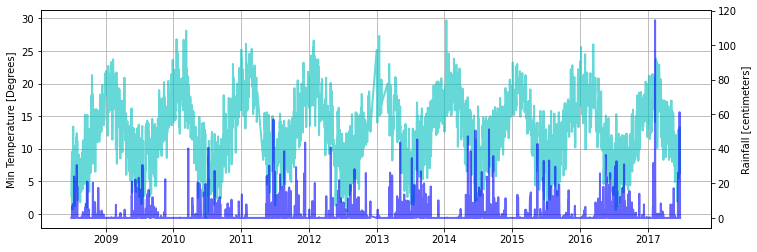

In [147]:
# create initial axis
fig, ax1 = plt.subplots(figsize = (12, 4))

# create a twin of that axis, that shares the same x axis 
ax2 = ax1.twinx()

# add data
ax1.plot(perth['Date'], perth['MinTemp'], c = 'c', linewidth = 2, alpha = 0.6, label = 'MinTemp')
ax1.set_ylabel('Min Temperature [Degrees]')
ax2.plot(perth['Date'], perth['Rainfall'], c = 'b', linewidth = 2, alpha = 0.6,  label = 'Rainfall')
ax2.set_ylabel('Rainfall [centimeters]')
ax1.grid()

Much better! Now we can see what is going on with both variables. 

<hr style="border:2px solid gray"> </hr>

### Now you try

Plot `Rainfall` and `Pressure3pm` on the same axis in a way that is easy to comprehend. 

(14061.0, 14161.0)

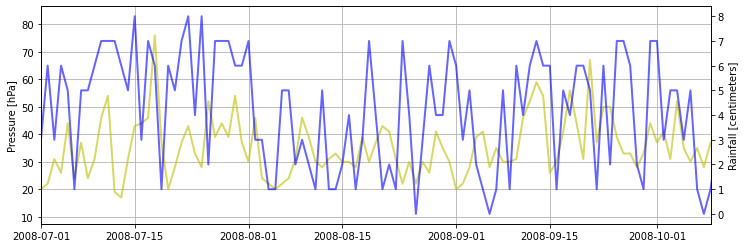

In [148]:
### BEGIN SOLUTION 

fig, ax1 = plt.subplots(figsize = (12, 4))
ax2 = ax1.twinx()

# add data
ax1.plot(perth['Date'], perth['WindGustSpeed'], c = 'y', linewidth = 2, alpha = 0.6, label = 'MinTemp')
ax1.set_ylabel('Pressure [hPa]')
ax2.plot(perth['Date'], perth['Cloud3pm'], c = 'b', linewidth = 2, alpha = 0.6,  label = 'Rainfall')
ax2.set_ylabel('Rainfall [centimeters]')
ax1.grid() 
ax1.set_xlim(perth['Date'][0], perth['Date'][100])
### END SOLUTION 

<hr style="border:2px solid gray"> </hr>

## Time lagged cross corelations 

Another useful method for quantifying the correlation (if any) between two time series is using **time lagged cross correlation**. This compares one time series to a lagged version of another time series - kind of like a ACF but instead of comparing to a lagged version of itself, it is compared to a lagged version of another variable. 

This is a very important technique because it helps us see if one variable is **leading** the other. In other words, if changes in one variable indicate a change coming in another. 

Let's try to do this with our `Evaporation` and `MaxTemp` variables, using the `statsmodels.tsa.stattools.ccf` function. We simply need to input the two time series, and then plot the resulting array. 

array([0.79886433, 0.81800683, 0.73843008, ..., 0.83010477, 0.68371357,
       1.19327   ])

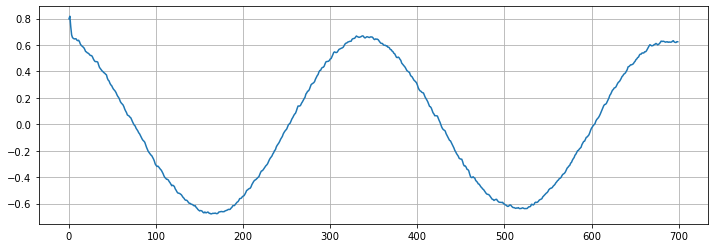

In [165]:
perth_ccf = sm.tsa.stattools.ccf(perth['Evaporation'], perth['MaxTemp'])

plt.figure(figsize = (12, 4))
plt.plot(perth_ccf[0:700])
plt.grid()
perth_ccf

This indicates to us that We see the highest autocorrelation between the two variables is on the same day. Then, it drops and after that first day the two variables are related on the same yearly seasonal cycle we've been seeing in all the variables. While this is an illuminating result, let's do this again with some simulated data so you can really see what the function is doing. 

## dynamic time warping OR instantaneous phase synchrony